Modified January 2020
@author: Samir Akre

- Modified to work on 20x images

---
Created on Aug 20, 2019

@author:     Ruchika Verma

Description: Nuclei segmentation using Mask-RCNN and based on Feature Pyramid Network (FPN) and a ResNet 50
             backbone.
            
This model was trained using data from our TMI paper and MoNuSeg challenge
  
Please cite the following paper and our MoNuSeg (https://monuseg.grand-challenge.org/) challenge if you use
this code-

N. Kumar, R. Verma, S. Sharma, S. Bhargava, A. Vahadane and A. Sethi, "A Dataset and a Technique for Generalized Nuclear Segmentation for Computational Pathology," in IEEE Transactions on Medical Imaging, 
vol. 36, no. 7, pp. 1550-1560, July 2017

In [1]:
# Import Mask RCNN and load my weights of my trained model
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from mrcnn import visualize
import mrcnn.model as modellib
import nucleus
import tensorflow as tf
from scipy.io import savemat
config = nucleus.NucleusInferenceConfig()
config.display()
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
with tf.device(DEVICE):
    nmodel = modellib.MaskRCNN(mode="inference",
                              model_dir=os.getcwd(),
                              config=config)
weights_path = "/Users/akre96/Data/BE_223B/mask_rcnn_weights.h5"
nmodel.load_weights(weights_path, by_name=True)  

/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/akre96/Code/tool_repositories/MoNuSeg/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
tile_path = '/Users/akre96/Data/BE_223B/tiles_rois/normalized/15123_90496_18816.png'
tile = skimage.io.imread(tile_path)
scaled_tile = skimage.transform.rescale(tile, 2, multichannel=True) * 255
patch_size = scaled_tile.shape[0]

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min:  -39.56000  max:  211.44000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


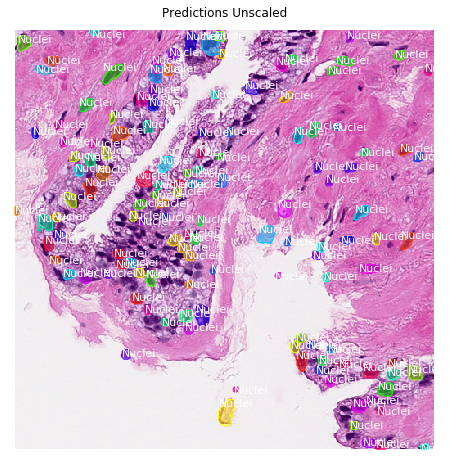

In [3]:
results = nmodel.detect([tile], verbose=1)
r = results[0]
visualize.display_instances(
    tile,
    r['rois'],
    r['masks'],
    r['class_ids'],
    ['BG', 'Nuclei'],
    figsize=(8, 8), ax=None,
    show_mask=True, show_bbox=False,
    title="Predictions Unscaled"
)

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  252.06250  float64
molded_images            shape: (1, 2048, 2048, 3)    min:  -39.56000  max:  210.04937  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 1047552, 4)       min:   -0.04422  max:    1.01295  float32


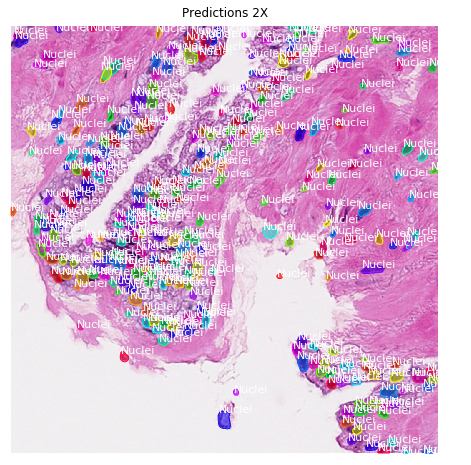

In [4]:
results = nmodel.detect([scaled_tile], verbose=1)
r = results[0]
visualize.display_instances(
    scaled_tile,
    r['rois'],
    r['masks'],
    r['class_ids'],
    ['BG', 'Nuclei'],
    figsize=(8, 8), ax=None,
    show_mask=True, show_bbox=False,
    title="Predictions 2X"
)

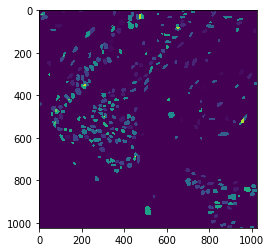

In [6]:
# Generate an n-ary nuclei mask 
individual_nuclei = r['masks']
predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
n_nuc = 0
for k in range(individual_nuclei.shape[2]):
    n_nuc += 1
    nuc_mask = r['masks'][:,:,k]
    predicted_nuclei += (n_nuc)*nuc_mask
plt.imshow(predicted_nuclei)


In [8]:
## Create mask of individual nuclei for all monuseg test data
data_path = '/Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/'
out_path = '/Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/predicted_masks'
patch_size = 1000

test_files = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.split('.')[1] == 'tif']

In [28]:
for file in test_files:
    print('Predicting on:', file)
    tile = skimage.io.imread(file)
    fn = file.split('.')[0]
    results = nmodel.detect([tile], verbose=0)
    r = results[0]
    individual_nuclei = r['masks']
    predicted_nuclei = np.zeros((patch_size,patch_size), dtype = int)
    n_nuc = 0
    print('\tCreating Mask')
    for k in range(individual_nuclei.shape[2]):
        n_nuc += 1
        nuc_mask = r['masks'][:,:,k]
        predicted_nuclei += (n_nuc)*nuc_mask
    outname = os.path.join(
        out_path,
        fn + '_predicted.mat'
    )
    print('\tSaving to:', outname)
    savemat(
        outname,
        {'predicted_mask': predicted_nuclei}
    )



Predicting on: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-IZ-8196-01A-01-BS1.tif
	Creating Mask
	Saving to: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-IZ-8196-01A-01-BS1_predicted.mat
Predicting on: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-69-7764-01A-01-TS1.tif
	Creating Mask
	Saving to: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-69-7764-01A-01-TS1_predicted.mat
Predicting on: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-HT-8564-01Z-00-DX1.tif
	Creating Mask
	Saving to: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-HT-8564-01Z-00-DX1_predicted.mat
Predicting on: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-A6-6782-01A-01-BS1.tif
	Creating Mask
	Saving to: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-A6-6782-01A-01-BS1_predicted.mat
Predicting on: /Users/akre96/Data/BE_223B/MoNuSeg_Test_Set/MoNuSegTestData/TCGA-ZF-A9R5-

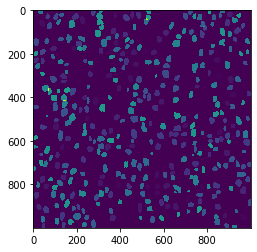